In [ ]:
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# STEP 2 — Load dataset
df = pd.read_csv("/content/customer_churn_dataset-training-master.csv")
print("Original Dataset Shape:", df.shape)

# 🛠 FIX — Remove rows with missing target
df = df.dropna(subset=["Churn"])
print("After Removing NaN in Churn:", df.shape)

# STEP 3 — Reduce Dataset Size
df_small, _ = train_test_split(
    df,
    train_size=0.20,
    stratify=df["Churn"],
    random_state=42
)

print("Reduced Dataset Shape:", df_small.shape)

df = df_small.copy()


Original Dataset Shape: (440833, 12)
After Removing NaN in Churn: (440832, 12)
Reduced Dataset Shape: (88166, 12)


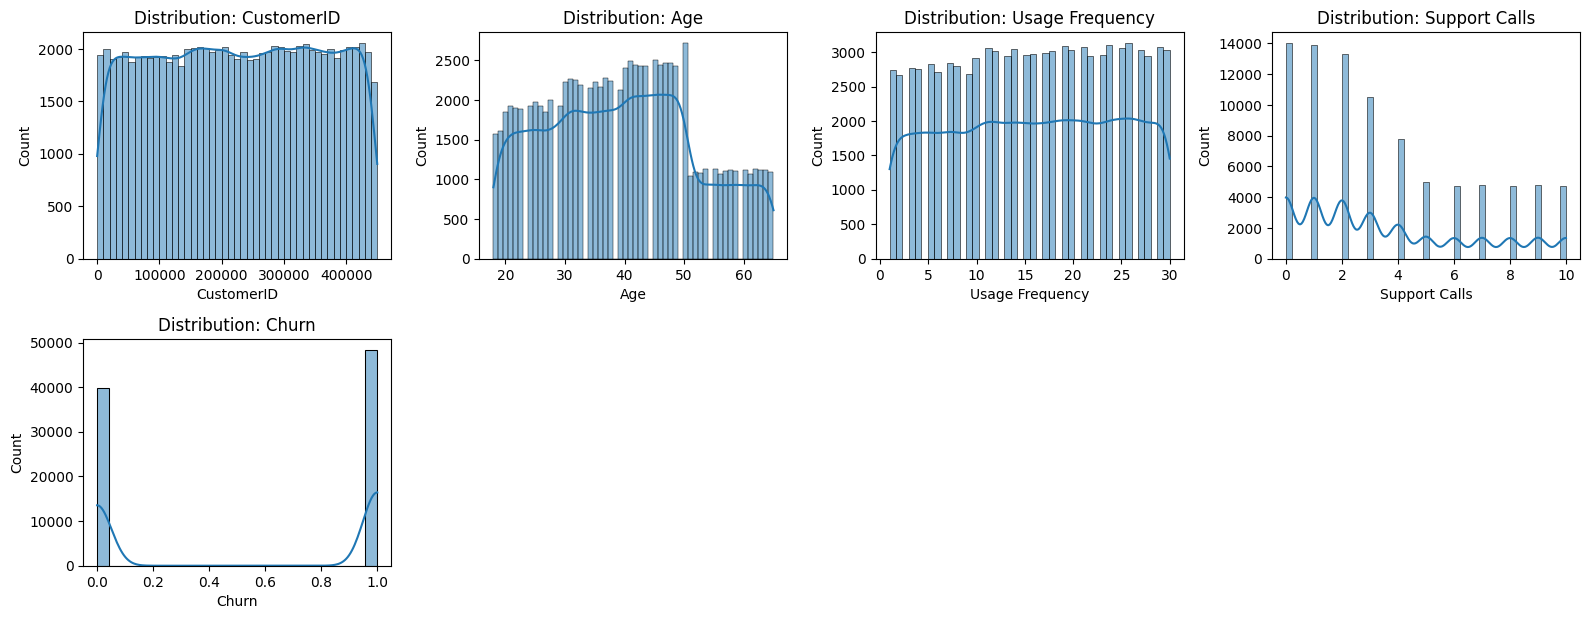

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 3(a) DISTRIBUTION PLOTS
# ================================

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution: {col}", fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipython-input-2935903658.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette="viridis")


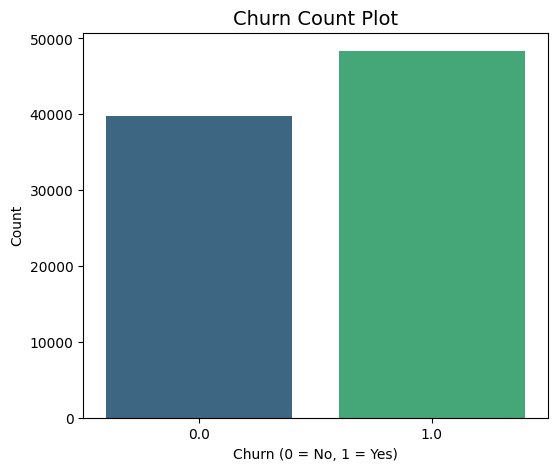

In [ ]:
# ================================
# 3(b) CHURN COUNT PLOT
# ================================

plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="Churn", palette="viridis")
plt.title("Churn Count Plot", fontsize=14)
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


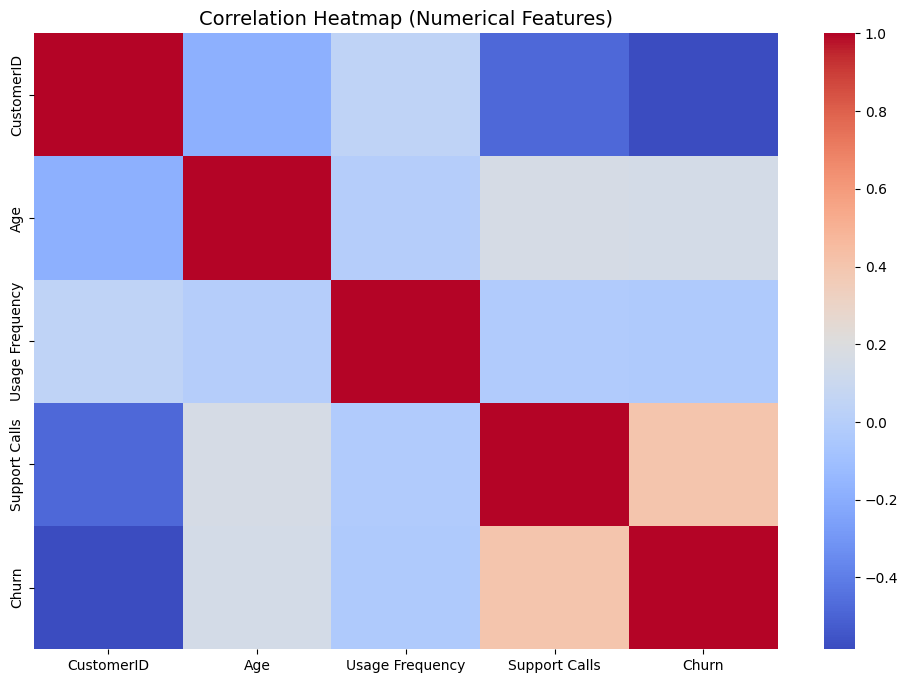

In [ ]:
# ================================
# 3(c) CORRELATION HEATMAP
# ================================

plt.figure(figsize=(12, 8))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)", fontsize=14)
plt.show()


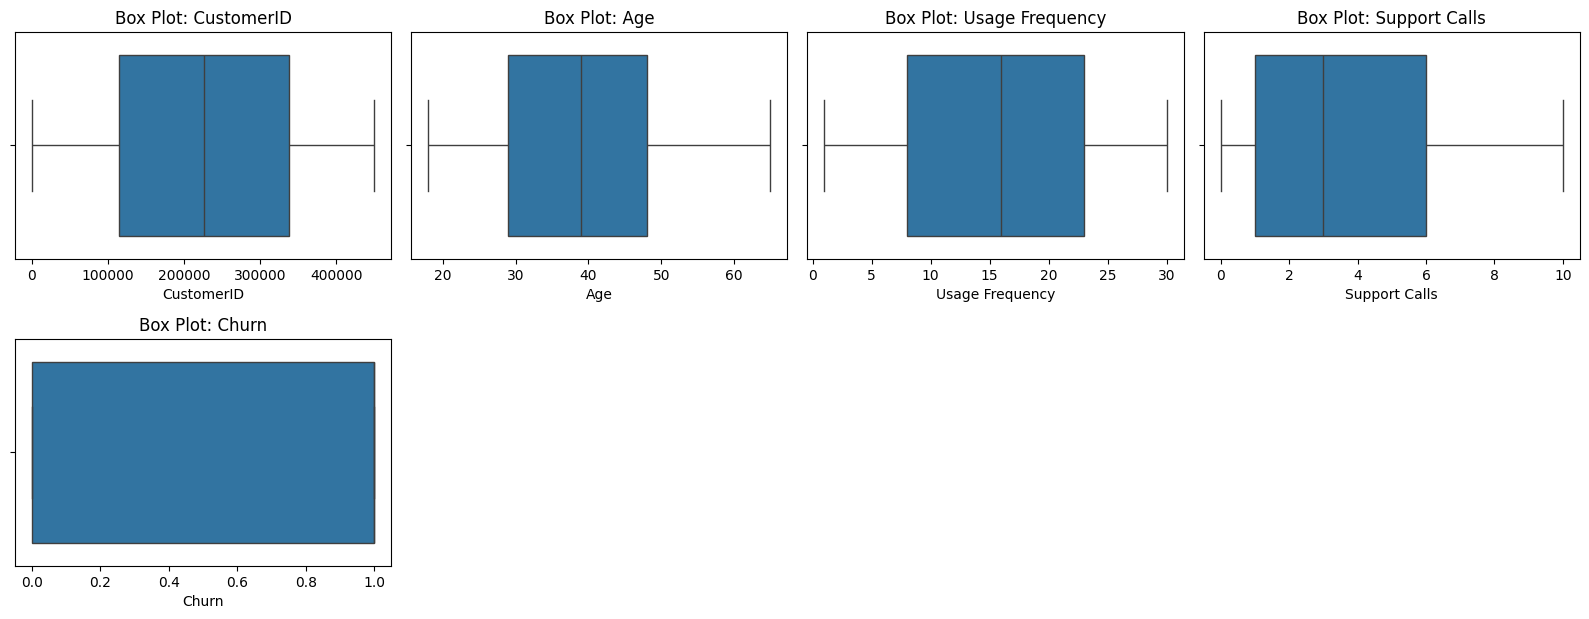

In [ ]:
# ================================
# 3(d) BOX PLOTS FOR OUTLIERS
# ================================

plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot: {col}")

plt.tight_layout()
plt.show()


In [ ]:

# 3. Remove strong features
columns_to_remove = ["Total Spend", "Tenure", "Last Interaction", "Payment Delay"]
df = df.drop(columns=columns_to_remove, errors="ignore")

# Reduce label noise from 30% to 15%
n = int(len(df) * 0.15)
indices = np.random.choice(df.index, n, replace=False)
df.loc[indices, "Churn"] = 1 - df.loc[indices, "Churn"]

In [ ]:
#we seprated infromation from the  target
X = df.drop(columns=["Churn"])
y = df["Churn"]


In [ ]:
# =========================================
# 3. DATA CLEANING & PREPROCESSING
# =========================================

# Automatically detect categorical & numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# ---- 3.1 Handle Missing Values ----
# Fill categorical NA with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical NA with mean
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

# ---- 3.2 Separate features & target ----
X = df.drop("Churn", axis=1)
y = df["Churn"]

# ---- 3.3 Preprocessing ----
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# ---- 3.4 Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# =========================================
# 4. LOGISTIC REGRESSION MODEL
# =========================================

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# 4.1 — Create Pipeline
# -------------------------------

log_reg_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=200))
])

# -------------------------------
# 4.2 — Train the Model
# -------------------------------

log_reg_model.fit(X_train, y_train)

# -------------------------------
# 4.3 — Make Predictions
# -------------------------------

y_pred = log_reg_model.predict(X_test)

# -------------------------------
# 4.4 — Evaluate Model
# -------------------------------

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

y_pred_proba = log_reg_model.predict_proba(X_test)

# Optional: Print the first 5 probability predictions
print("First 5 probability predictions:\n")
# If you are working with binary classification, y_pred_proba[:, 1]
# gives the probability of the positive class
print(y_pred_proba[:5])

Logistic Regression Accuracy: 0.7293

Classification Report:

              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71      8239
         1.0       0.74      0.76      0.75      9395

    accuracy                           0.73     17634
   macro avg       0.73      0.73      0.73     17634
weighted avg       0.73      0.73      0.73     17634

First 5 probability predictions:

[[0.31056625 0.68943375]
 [0.35145781 0.64854219]
 [0.66300662 0.33699338]
 [0.77323888 0.22676112]
 [0.30236311 0.69763689]]


In [ ]:
# Convert transformed X_test back to original form
X_test_reset = X_test.reset_index(drop=True)

# Predicted class labels
pred_class = log_reg_model.predict(X_test)

# Predicted probabilities (probability of class = 1)
pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Create a single dataframe to show everything
results_df = X_test_reset.copy()
results_df["Actual_Churn"] = y_test.reset_index(drop=True)
results_df["Predicted_Churn"] = pred_class
results_df["Probability_of_Churn"] = pred_proba

# Print first 10 rows
print(results_df.head(10))


   CustomerID   Age  Gender  Usage Frequency  Support Calls Subscription Type  \
0    208054.0  43.0    Male             19.0            7.0             Basic   
1    187192.0  29.0  Female             15.0            2.0             Basic   
2    330669.0  41.0    Male              5.0            2.0          Standard   
3    415318.0  48.0    Male             14.0            1.0          Standard   
4     85150.0  52.0    Male             28.0            3.0          Standard   
5    346487.0  26.0    Male              3.0            2.0             Basic   
6    195940.0  42.0    Male             11.0            8.0           Premium   
7    329563.0  49.0  Female             14.0            3.0          Standard   
8    318562.0  42.0    Male             12.0            3.0           Premium   
9    411772.0  44.0  Female             18.0            3.0             Basic   

  Contract Length  Actual_Churn  Predicted_Churn  Probability_of_Churn  
0         Monthly           1.0    

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

print("\n📌 Showing first 10 predictions with probabilities:\n")
display(results_df.head(10))


📌 Showing first 10 predictions with probabilities:



,CustomerID,Age,Gender,Usage Frequency,Support Calls,Subscription Type,Contract Length,Actual_Churn,Predicted_Churn,Probability_of_Churn
0,208054.0,43.0,Male,19.0,7.0,Basic,Monthly,1.0,1.0,0.689434
1,187192.0,29.0,Female,15.0,2.0,Basic,Monthly,1.0,1.0,0.648542
2,330669.0,41.0,Male,5.0,2.0,Standard,Quarterly,1.0,0.0,0.336993
3,415318.0,48.0,Male,14.0,1.0,Standard,Annual,0.0,0.0,0.226761
4,85150.0,52.0,Male,28.0,3.0,Standard,Quarterly,1.0,1.0,0.697637
5,346487.0,26.0,Male,3.0,2.0,Basic,Annual,0.0,0.0,0.303309
6,195940.0,42.0,Male,11.0,8.0,Premium,Monthly,1.0,1.0,0.715220
7,329563.0,49.0,Female,14.0,3.0,Standard,Quarterly,0.0,0.0,0.392804
8,318562.0,42.0,Male,12.0,3.0,Premium,Annual,0.0,0.0,0.366528
9,411772.0,44.0,Female,18.0,3.0,Basic,Annual,0.0,0.0,0.283928


In [ ]:
# =========================================
# 5. RANDOM FOREST MODEL
# =========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# -------------------------------
# 5.1 — Create Pipeline
# -------------------------------

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=53
    ))
])

# -------------------------------
# 5.2 — Train the Model
# -------------------------------

rf_model.fit(X_train, y_train)

# -------------------------------
# 5.3 — Make Predictions
# -------------------------------

rf_pred = rf_model.predict(X_test)

# -------------------------------
# 5.4 — Evaluate Model
# -------------------------------

rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}\n")

print("Classification Report (Random Forest):\n")
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.7150

Classification Report (Random Forest):

              precision    recall  f1-score   support

         0.0       0.71      0.66      0.68      8239
         1.0       0.72      0.77      0.74      9395

    accuracy                           0.71     17634
   macro avg       0.71      0.71      0.71     17634
weighted avg       0.71      0.71      0.71     17634



Logistic Regression AUC: 0.7396118139295311
Random Forest AUC: 0.734537452520273


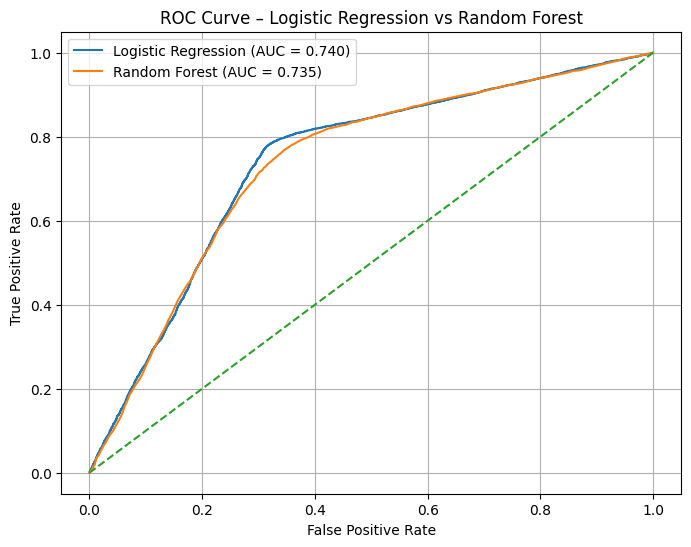

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# =========================================
# 6. ROC & AUC CURVES
# =========================================

# -------------------------------
# 6.1 — Logistic Regression ROC–AUC
# -------------------------------

log_probs = log_reg_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, log_probs)
print("Logistic Regression AUC:", log_auc)

# -------------------------------
# 6.2 — Random Forest ROC–AUC
# -------------------------------

rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
print("Random Forest AUC:", rf_auc)

# -------------------------------
# 6.3 — Plot ROC Curve
# -------------------------------

log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(log_fpr, log_tpr, label=f"Logistic Regression (AUC = {log_auc:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--")  # baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression vs Random Forest")
plt.legend()
plt.grid(True)
plt.show()


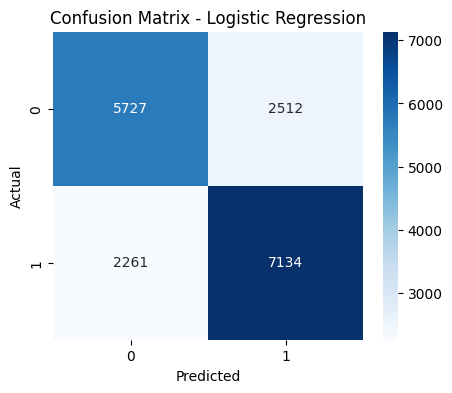

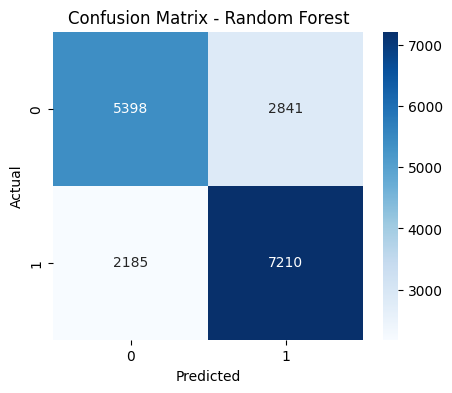

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================
# 7. CONFUSION MATRICES
# =========================================

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Logistic Regression
plot_conf_matrix(y_test, y_pred, "Confusion Matrix - Logistic Regression")

# Random Forest
plot_conf_matrix(y_test, rf_pred, "Confusion Matrix - Random Forest")


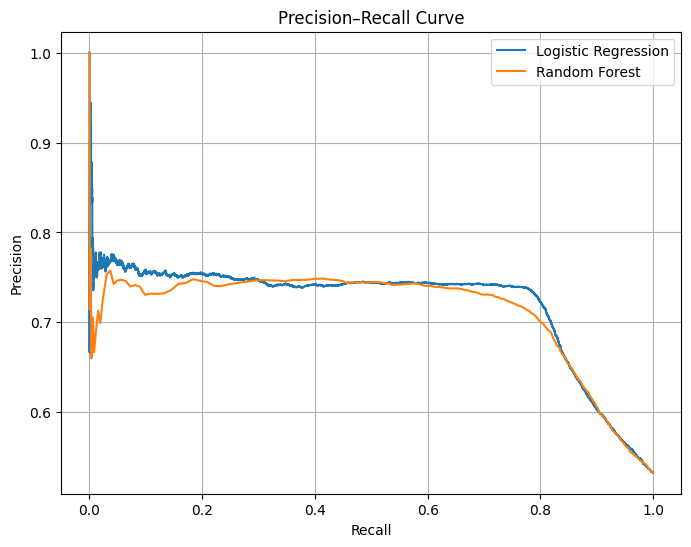

Logistic Regression AP Score: 0.7208794561555542
Random Forest AP Score: 0.7129584914475797


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# =========================================
# 8. PRECISION–RECALL CURVE
# =========================================

log_probs = log_reg_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

log_precision, log_recall, _ = precision_recall_curve(y_test, log_probs)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(log_recall, log_precision, label="Logistic Regression")
plt.plot(rf_recall, rf_precision, label="Random Forest")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

print("Logistic Regression AP Score:", average_precision_score(y_test, log_probs))
print("Random Forest AP Score:", average_precision_score(y_test, rf_probs))


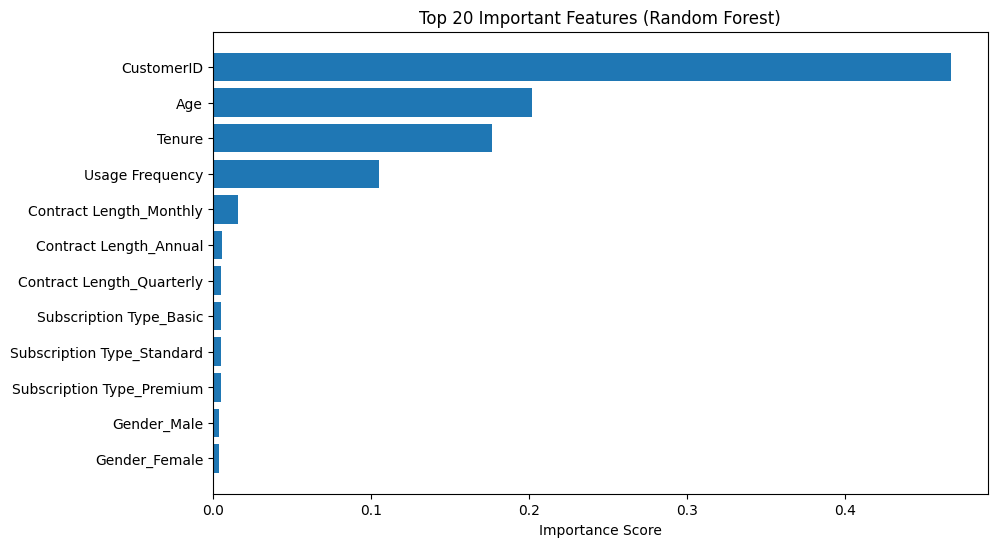

In [ ]:

 =========================================
# 9. FEATURE IMPORTANCE – RANDOM FOREST
# =========================================

# Step 1: Get one-hot encoded feature names
encoded_cat_cols = rf_model.named_steps["preprocess"] \
                           .named_transformers_["cat"] \
                           .get_feature_names_out(categorical_cols)

# Step 2: Combine numeric + encoded categorical
all_features = np.concatenate([encoded_cat_cols, numerical_cols])

# Step 3: Extract feature importance from RF
importances = rf_model.named_steps["classifier"].feature_importances_

# Step 4: Sort by importance
sorted_idx = np.argsort(importances)[::-1]

# Step 5: Plot
plt.figure(figsize=(10,6))
plt.barh([all_features[i] for i in sorted_idx[:20]],
         [importances[i] for i in sorted_idx[:20]])
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()
